In [27]:
import jax
import jax.numpy as jnp
from jax import jit
from jax import grad
from jax import jacfwd, jacrev
from jax import random
from jax import vmap

import matplotlib.pyplot as plt
import numpy as np

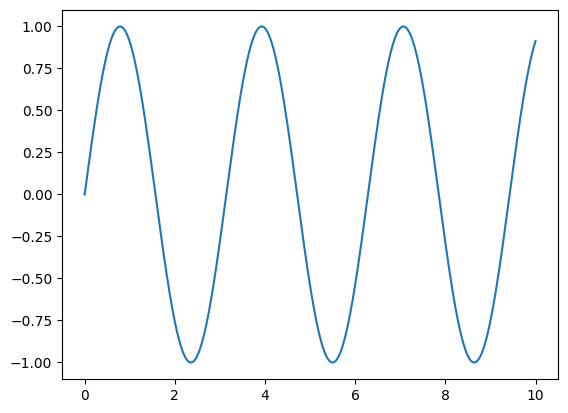

In [2]:

x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [ ]:
x = jnp.arange(5)
x.devices()

{CpuDevice(id=0)}

In [9]:
def norm(X):
  X = X - X.mean(0)
  return X / X.std(0)

norm_compiled = jit(norm)

In [10]:
np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
np.allclose(norm(X), norm_compiled(X), atol=1E-6)

True

In [11]:
%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

172 μs ± 14 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
151 μs ± 3.04 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [14]:
def sum_logistic(x):
  return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


In [16]:
def first_finite_differences(f, x, eps=1E-5):
  return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])

print(first_finite_differences(sum_logistic, x_small))

[0.2503395  0.19073486 0.10728836]


In [ ]:
def hessian(fun):
  return jit(jacfwd(jacrev(fun)))
print(hessian(sum_logistic)(x_small))

[[-0.         -0.         -0.        ]
 [-0.         -0.09085776 -0.        ]
 [-0.         -0.         -0.07996249]]


In [23]:

key = random.key(1701)
key1, key2 = random.split(key)
mat = random.normal(key1, (150, 100))
batched_x = random.normal(key2, (10, 100))

def apply_matrix(x):
  return jnp.dot(mat, x)

In [24]:
def naively_batched_apply_matrix(v_batched):
  return jnp.stack([apply_matrix(v) for v in v_batched])

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
209 μs ± 3.33 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:

@jit
def batched_apply_matrix(batched_x):
  return jnp.dot(batched_x, mat.T)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
6.06 μs ± 32.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
@jit
def vmap_batched_apply_matrix(batched_x):
  return vmap(apply_matrix)(batched_x)

np.testing.assert_allclose(naively_batched_apply_matrix(batched_x),
                           vmap_batched_apply_matrix(batched_x), atol=1E-4, rtol=1E-4)
print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
13.2 μs ± 256 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [29]:

key = random.key(43)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 43]


In [30]:
for i in range(3):
  new_key, subkey = random.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = random.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.

draw 0: -1.9133632183074951
draw 1: -1.4749839305877686
draw 2: -0.36703771352767944
